In [ ]:
# EXPLANATION: Adds the project's source folder to the system path so we can import custom helper functions. Initializes a Spark session.
# Add src to path so we can import pyspark_utils
import sys
import os
sys.path.append(os.path.abspath('../'))
from src.pyspark_utils import build_spark, read_csv, assemble_features, generate_dummy_data

# Initialize Spark Session (Local mode for stability in this demo)
spark = build_spark(app_name="Alzheimer-Disease-Prediction", master="local[*]")
spark

# Alzheimer's Disease Prediction with Spark MLlib
This notebook uses the **Alzheimer's Disease Dataset** to predict the presence of Alzheimer's disease.
It cleans and prepares the data, builds MLlib models (LogisticRegression, RandomForest, LinearSVC), compares against a scikit-learn baseline, and interprets results.

In [ ]:
# EXPLANATION: Imports necessary libraries (Pandas, NumPy, Matplotlib, Spark MLlib). Re-initializes Spark session.
# Imports and Spark session
import os, json, shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, LinearSVC
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.linear_model import LogisticRegression as SkLR
from sklearn.ensemble import RandomForestClassifier as SkRF
# import shap  <-- Removed to speed up container startup

spark = SparkSession.builder.appName('Alzheimer-Disease-Prediction').master('spark://spark-master:7077').getOrCreate()
spark

## Load Dataset
We use the **Alzheimer's Disease** dataset available in the `data/` directory.


In [ ]:
# EXPLANATION: Sets the path to the data directory and checks if it exists.
# Define data directory
data_dir = '/home/jovyan/work/data'
# If running locally (not in the container structure), adjust path if needed
if not os.path.exists(data_dir):
    data_dir = os.path.abspath('../data')

print(f"Data directory: {data_dir}")

Data directory: /home/jovyan/work/data


## Load and inspect data (Pandas)
We start with Pandas for quick inspection; later we move to Spark for distributed training.

In [ ]:
# EXPLANATION: Searches for the Alzheimer's CSV file, loads it into a Pandas DataFrame, and displays the first 5 rows.
# Load Data
import glob

# Look for alzheimer_data_2.csv
target_csv = os.path.join(data_dir, 'alzheimer_data_2.csv')

if os.path.exists(target_csv):
    csv_path = target_csv
else:
    # Fallback to searching
    csv_files = glob.glob(os.path.join(data_dir, '*alzheimer*.csv'))
    if len(csv_files) > 0:
        csv_path = csv_files[0]
    else:
        print("No Alzheimer dataset found.")
        csv_path = None

if csv_path:
    print(f"Loading data from: {csv_path}")
    # 4. Read into Pandas
    df_pd = pd.read_csv(csv_path)
    print(f"Data shape: {df_pd.shape}")
    df_pd.head()
else:
    raise FileNotFoundError("Please ensure alzheimer_data_2.csv is in the data directory.")

Loading data from: /home/jovyan/work/data/alzheimer_data_2.csv
Data shape: (2149, 35)


## Basic cleaning and label handling
Convert labels to binary (presence/absence). Handle missing values.

In [ ]:
# EXPLANATION: Identifies the target 'Diagnosis' column, drops useless ID columns, and fills missing values with the median.
# Identify label column
label_col = 'Diagnosis'

if label_col not in df_pd.columns:
    # Fallback if using the other dataset
    if 'Group' in df_pd.columns:
        label_col = 'Group'
        # Convert Group to binary if needed (Demented=1, Nondemented=0)
        df_pd['Group'] = df_pd['Group'].apply(lambda x: 1 if x == 'Demented' else 0)
    else:
        print(f"Warning: '{label_col}' column not found. Using last column.")
        label_col = df_pd.columns[-1]

print(f"Label column: {label_col}")

# Drop non-predictive columns
cols_to_drop = ['PatientID', 'DoctorInCharge']
df_pd = df_pd.drop(columns=[c for c in cols_to_drop if c in df_pd.columns])

# Handle missing values
df_pd = df_pd.replace([np.inf, -np.inf], np.nan)
# Fill numeric missing values with median
df_pd = df_pd.fillna(df_pd.median(numeric_only=True))

feature_cols = [c for c in df_pd.columns if c != label_col]
print(f"Features: {feature_cols}")
df_pd[feature_cols].describe().T.head(10)

Label column: Diagnosis
Features: ['Age', 'Gender', 'Ethnicity', 'EducationLevel', 'BMI', 'Smoking', 'AlcoholConsumption', 'PhysicalActivity', 'DietQuality', 'SleepQuality', 'FamilyHistoryAlzheimers', 'CardiovascularDisease', 'Diabetes', 'Depression', 'HeadInjury', 'Hypertension', 'SystolicBP', 'DiastolicBP', 'CholesterolTotal', 'CholesterolLDL', 'CholesterolHDL', 'CholesterolTriglycerides', 'MMSE', 'FunctionalAssessment', 'MemoryComplaints', 'BehavioralProblems', 'ADL', 'Confusion', 'Disorientation', 'PersonalityChanges', 'DifficultyCompletingTasks', 'Forgetfulness']


,count,mean,std,min,25%,50%,75%,max
Age,2149.0,74.908795,8.990221,60.000000,67.000000,75.000000,83.000000,90.000000
Gender,2149.0,0.506282,0.500077,0.000000,0.000000,1.000000,1.000000,1.000000
Ethnicity,2149.0,0.697534,0.996128,0.000000,0.000000,0.000000,1.000000,3.000000
EducationLevel,2149.0,1.286645,0.904527,0.000000,1.000000,1.000000,2.000000,3.000000
BMI,2149.0,27.655697,7.217438,15.008851,21.611408,27.823924,33.869778,39.992767
Smoking,2149.0,0.288506,0.453173,0.000000,0.000000,0.000000,1.000000,1.000000
AlcoholConsumption,2149.0,10.039442,5.757910,0.002003,5.139810,9.934412,15.157931,19.989293
PhysicalActivity,2149.0,4.920202,2.857191,0.003616,2.570626,4.766424,7.427899,9.987429
DietQuality,2149.0,4.993138,2.909055,0.009385,2.458455,5.076087,7.558625,9.998346
SleepQuality,2149.0,7.051081,1.763573,4.002629,5.482997,7.115646,8.562521,9.999840


## Train/test split (Pandas/Sklearn baseline)
We'll fit a quick baseline using scikit-learn to compare against Spark MLlib.

In [ ]:
# EXPLANATION: Splits data into train/test sets (80/20). Trains a Scikit-Learn Logistic Regression model as a baseline benchmark.
X_train, X_test, y_train, y_test = train_test_split(df_pd[feature_cols], df_pd[label_col], test_size=0.2, random_state=42, stratify=df_pd[label_col])
# Baseline: Logistic Regression
sk_lr = SkLR(max_iter=500)
sk_lr.fit(X_train, y_train)
y_pred = sk_lr.predict(X_test)
y_prob = sk_lr.predict_proba(X_test)[:,1]
print(classification_report(y_test, y_pred))
print('ROC-AUC:', roc_auc_score(y_test, y_prob))

              precision    recall  f1-score   support

           0       0.85      0.87      0.86       278
           1       0.76      0.72      0.74       152

    accuracy                           0.82       430
   macro avg       0.80      0.80      0.80       430
weighted avg       0.82      0.82      0.82       430

ROC-AUC: 0.8825728890571753


/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Move to Spark: create DataFrame and assemble features
We'll assemble features into a single vector and scale them.

In [ ]:
# EXPLANATION: Converts Pandas DF to Spark DF. Combines features into a single vector and scales them using StandardScaler.
df_spark = spark.createDataFrame(df_pd)
assembler = VectorAssembler(inputCols=feature_cols, outputCol='features')
scaler = StandardScaler(inputCol='features', outputCol='scaledFeatures')
pipeline_prep = Pipeline(stages=[assembler, scaler])
df_prepared = pipeline_prep.fit(df_spark).transform(df_spark)
df_prepared.select('scaledFeatures', label_col).show(5)

+--------------------+---------+
|      scaledFeatures|Diagnosis|
+--------------------+---------+
|(32,[0,3,4,6,7,8,...|        0|
|(32,[0,4,6,7,8,9,...|        0|
|(32,[0,2,3,4,6,7,...|        0|
|(32,[0,1,3,4,5,6,...|        0|
|(32,[0,4,6,7,8,9,...|        0|
+--------------------+---------+
only showing top 5 rows



## MLlib models: Logistic Regression, Random Forest, Linear SVC
We train multiple classifiers and evaluate AUC.

In [8]:
train_df, test_df = df_prepared.randomSplit([0.8, 0.2], seed=42)
evaluator = BinaryClassificationEvaluator(labelCol=label_col, rawPredictionCol='rawPrediction', metricName='areaUnderROC')

# Logistic Regression
lr = LogisticRegression(featuresCol='scaledFeatures', labelCol=label_col, maxIter=50)
lr_model = lr.fit(train_df)
lr_auc = evaluator.evaluate(lr_model.transform(test_df))
print('MLlib LogisticRegression ROC-AUC:', lr_auc)

# Random Forest
rf = RandomForestClassifier(featuresCol='scaledFeatures', labelCol=label_col, numTrees=100, maxDepth=8)
rf_model = rf.fit(train_df)
rf_auc = evaluator.evaluate(rf_model.transform(test_df))
print('MLlib RandomForest ROC-AUC:', rf_auc)

# Linear SVC
svm = LinearSVC(featuresCol='scaledFeatures', labelCol=label_col, maxIter=50)
svm_model = svm.fit(train_df)
svm_auc = evaluator.evaluate(svm_model.transform(test_df))
print('MLlib LinearSVC (approximated) ROC-AUC:', svm_auc)

MLlib LogisticRegression ROC-AUC: 0.9117241379310346
MLlib RandomForest ROC-AUC: 0.9680250783699059
MLlib LinearSVC (approximated) ROC-AUC: 0.9107962382445144


## Hyperparameter tuning (CrossValidator)
We'll use MLlib's CrossValidator with a small grid.

In [9]:
# Hyperparameter tuning for Logistic Regression
paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.01, 0.1, 0.5])
             .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])
             .build())

cv = CrossValidator(estimator=lr,
                    estimatorParamMaps=paramGrid,
                    evaluator=evaluator,
                    numFolds=3)

print("Running Cross-Validation...")
cvModel = cv.fit(train_df)
best_lr = cvModel.bestModel
print(f"Best RegParam: {best_lr.getRegParam()}")
print(f"Best ElasticNetParam: {best_lr.getElasticNetParam()}")
print(f"Best CV ROC-AUC: {max(cvModel.avgMetrics)}")

# Evaluate best model on test set
best_auc = evaluator.evaluate(best_lr.transform(test_df))
print(f"Test Set ROC-AUC of Best Model: {best_auc}")

Running Cross-Validation...
Best RegParam: 0.01
Best ElasticNetParam: 1.0
Best CV ROC-AUC: 0.8960414915846795
Test Set ROC-AUC of Best Model: 0.9199749216300942


/tmp/ipykernel_798/638015772.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette=['#66c2a5', '#fc8d62']) # Changed colors to green/orange


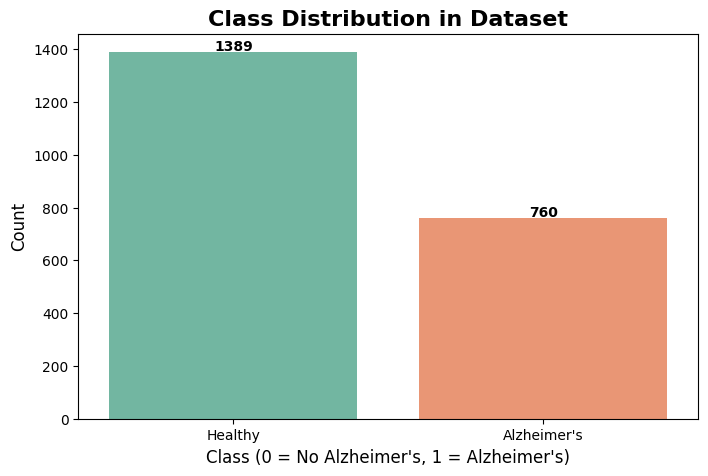

In [10]:
# 1. CLASS DISTRIBUTION
plt.figure(figsize=(8, 5))
class_counts = df_pd[label_col].value_counts()
sns.barplot(x=class_counts.index, y=class_counts.values, palette=['#66c2a5', '#fc8d62']) # Changed colors to green/orange
plt.title('Class Distribution in Dataset', fontsize=16, fontweight='bold')
plt.xlabel('Class (0 = No Alzheimer\'s, 1 = Alzheimer\'s)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks([0, 1], ['Healthy', 'Alzheimer\'s'])
for i, v in enumerate(class_counts.values):
    plt.text(i, v + 5, str(v), ha='center', fontweight='bold')
plt.show()

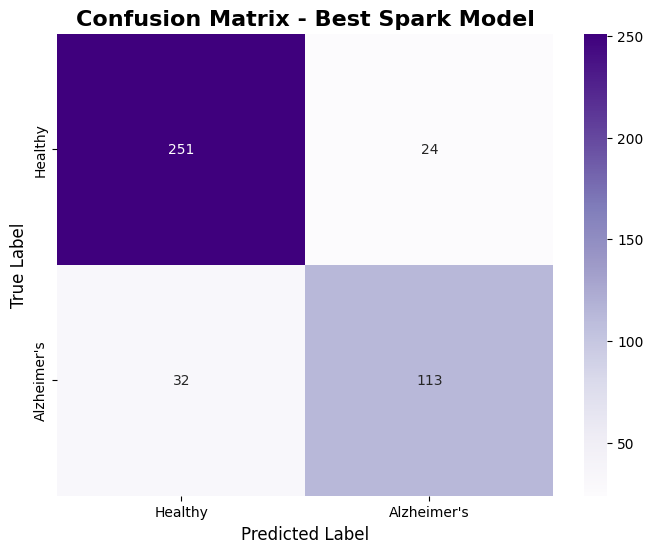

✅ True Negatives: 251 | ❌ False Positives: 24
❌ False Negatives: 32 | ✅ True Positives: 113


In [11]:
# 2. CONFUSION MATRIX
from sklearn.metrics import confusion_matrix

# Get predictions from best model
predictions = best_lr.transform(test_df)
y_true = predictions.select(label_col).toPandas()[label_col]
y_pred = predictions.select('prediction').toPandas()['prediction']

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', cbar=True, # Changed cmap to Purples
            xticklabels=['Healthy', 'Alzheimer\'s'], 
            yticklabels=['Healthy', 'Alzheimer\'s'])
plt.title('Confusion Matrix - Best Spark Model', fontsize=16, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.show()

print(f"✅ True Negatives: {cm[0,0]} | ❌ False Positives: {cm[0,1]}")
print(f"❌ False Negatives: {cm[1,0]} | ✅ True Positives: {cm[1,1]}")

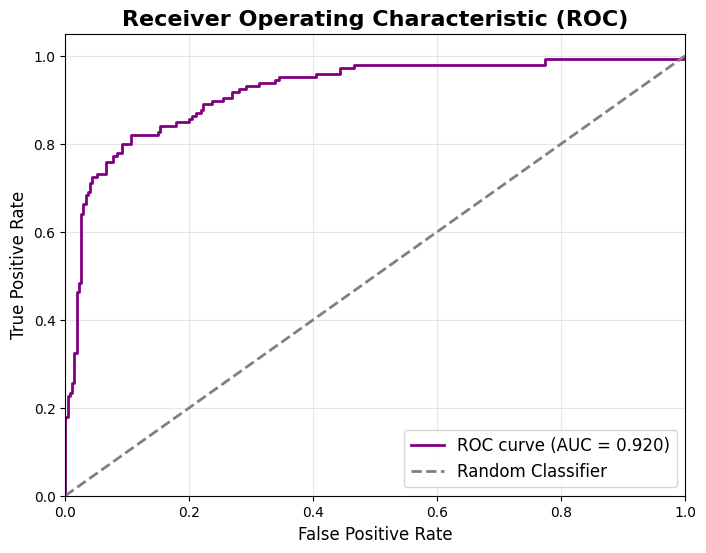

In [12]:
# 3. ROC CURVE
from sklearn.metrics import roc_curve, auc

y_prob = predictions.select('probability').toPandas()['probability'].apply(lambda x: x[1])
fpr, tpr, _ = roc_curve(y_true, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='purple', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})') # Changed color to purple
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Random Classifier') # Changed color to gray
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Receiver Operating Characteristic (ROC)', fontsize=16, fontweight='bold')
plt.legend(loc="lower right", fontsize=12)
plt.grid(alpha=0.3)
plt.show()

/tmp/ipykernel_798/2259402845.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Coefficient', y='Feature', data=feature_importance, palette=colors)


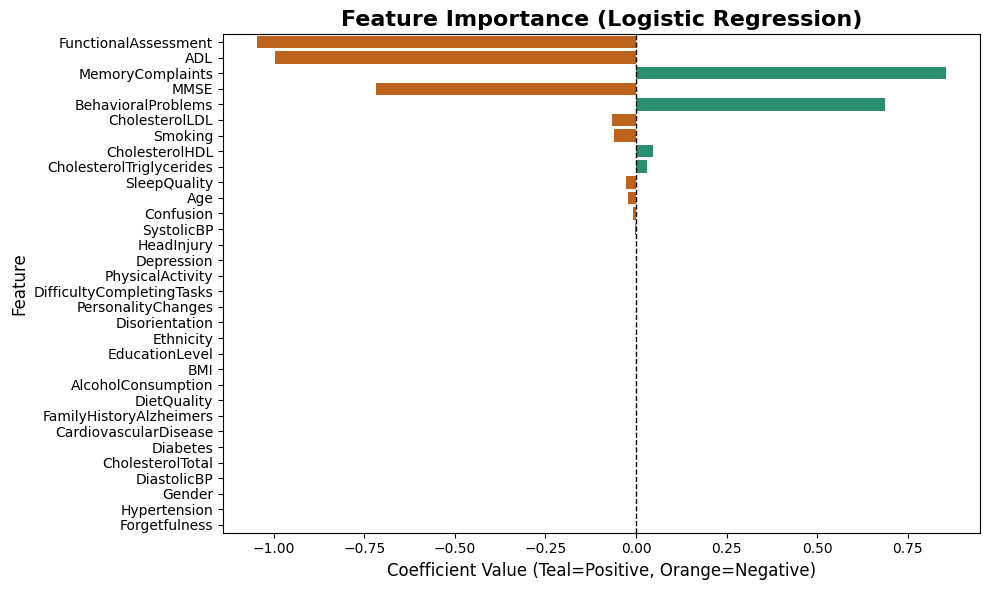


🔝 Top 5 Most Important Features:
                 Feature  Coefficient  Abs_Coefficient
23  FunctionalAssessment    -1.045283         1.045283
26                   ADL    -0.995562         0.995562
24      MemoryComplaints     0.854739         0.854739
22                  MMSE    -0.719090         0.719090
25    BehavioralProblems     0.687210         0.687210


In [13]:
# 4. FEATURE IMPORTANCE (Logistic Regression Coefficients)
coefficients = best_lr.coefficients.toArray()
feature_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Coefficient': coefficients,
    'Abs_Coefficient': np.abs(coefficients)
})
feature_importance = feature_importance.sort_values(by='Abs_Coefficient', ascending=False)

plt.figure(figsize=(10, 6))
colors = ['#1b9e77' if x > 0 else '#d95f02' for x in feature_importance['Coefficient']] # Changed colors to teal/orange
sns.barplot(x='Coefficient', y='Feature', data=feature_importance, palette=colors)
plt.title('Feature Importance (Logistic Regression)', fontsize=16, fontweight='bold')
plt.xlabel('Coefficient Value (Teal=Positive, Orange=Negative)', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.axvline(x=0, color='black', linestyle='--', linewidth=1)
plt.tight_layout()
plt.show()

print("\n🔝 Top 5 Most Important Features:")
print(feature_importance.head())

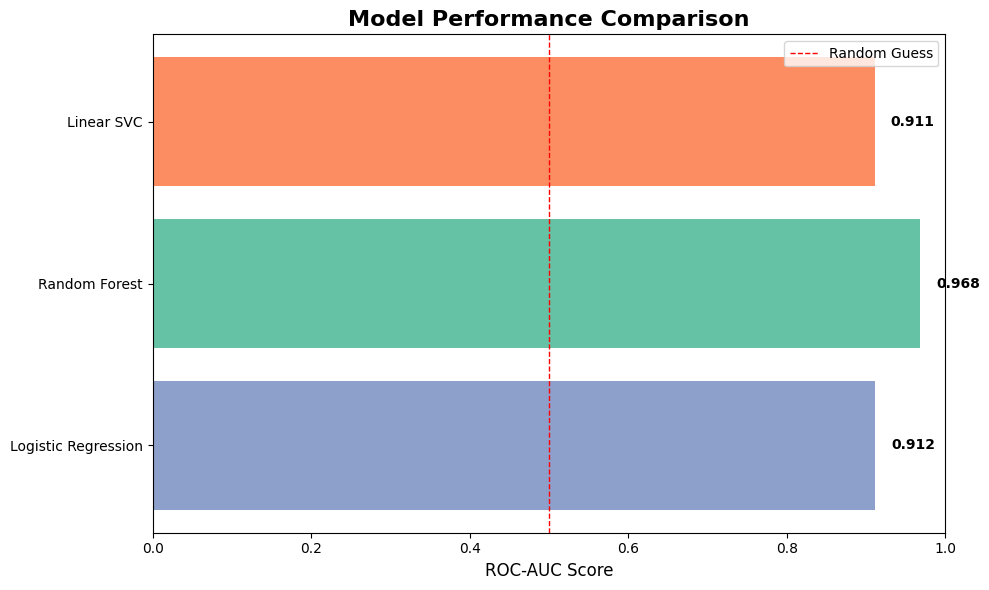


🏆 Best Model: Random Forest with AUC = 0.968


In [14]:
# 5. MODEL COMPARISON (AUC Scores)
model_names = ['Logistic Regression', 'Random Forest', 'Linear SVC']
auc_scores = [lr_auc, rf_auc, svm_auc]

plt.figure(figsize=(10, 6))
bars = plt.barh(model_names, auc_scores, color=['#8da0cb', '#66c2a5', '#fc8d62']) # Changed colors
plt.xlabel('ROC-AUC Score', fontsize=12)
plt.title('Model Performance Comparison', fontsize=16, fontweight='bold')
plt.xlim([0, 1])

# Add value labels on bars
for i, (bar, score) in enumerate(zip(bars, auc_scores)):
    plt.text(score + 0.02, i, f'{score:.3f}', va='center', fontweight='bold')

plt.axvline(x=0.5, color='red', linestyle='--', linewidth=1, label='Random Guess')
plt.legend()
plt.tight_layout()
plt.show()

print(f"\n🏆 Best Model: {model_names[auc_scores.index(max(auc_scores))]} with AUC = {max(auc_scores):.3f}")

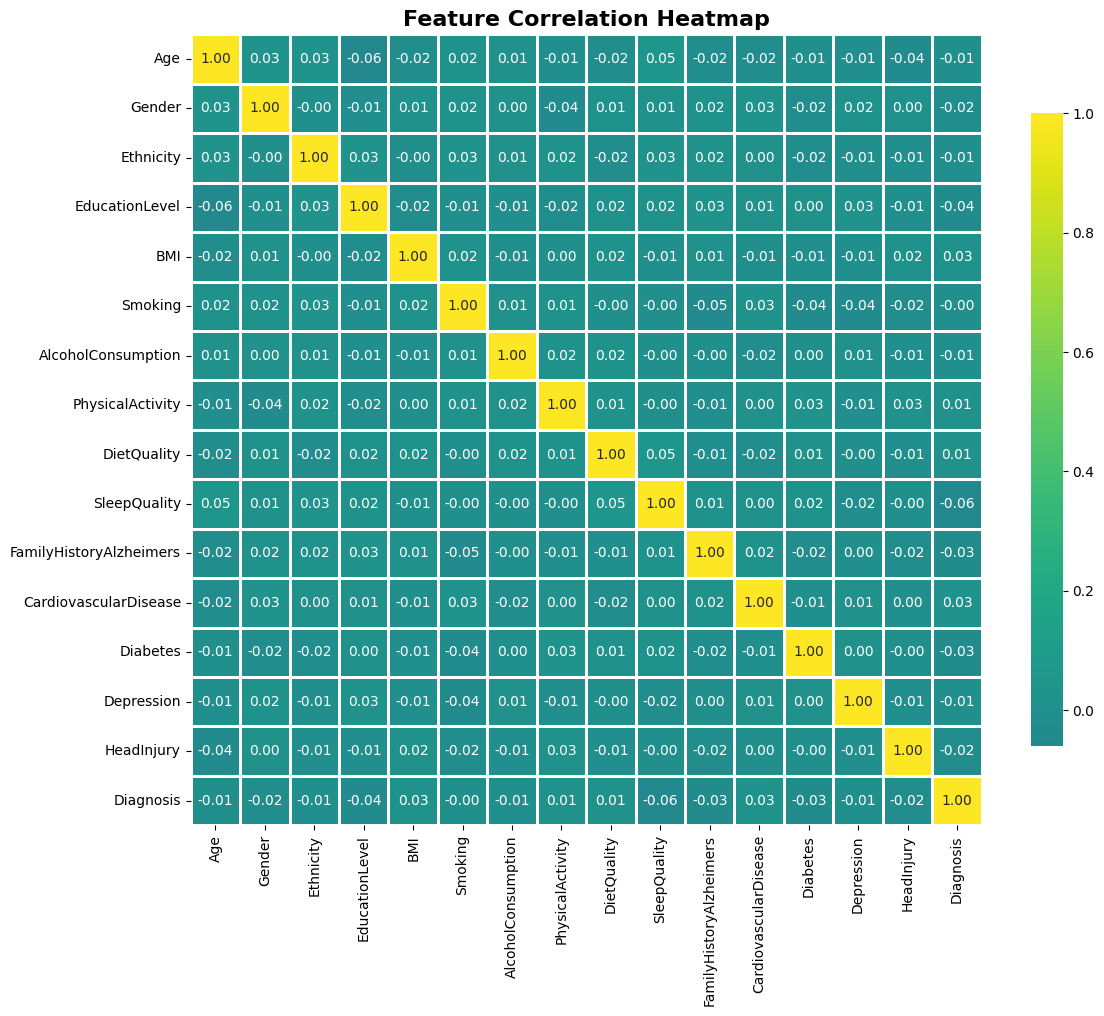


🔗 Features most correlated with Alzheimer's Disease:
SleepQuality               0.056548
EducationLevel             0.043966
FamilyHistoryAlzheimers    0.032900
Diabetes                   0.031508
CardiovascularDisease      0.031490
Name: Diagnosis, dtype: float64


In [15]:
# 6. CORRELATION HEATMAP
plt.figure(figsize=(12, 10))
# Select a subset of features if there are too many
corr_features = feature_cols[:15] + [label_col] if len(feature_cols) > 15 else feature_cols + [label_col]
correlation = df_pd[corr_features].corr()
sns.heatmap(correlation, annot=True, fmt='.2f', cmap='viridis', center=0, # Changed cmap to viridis
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Feature Correlation Heatmap', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n🔗 Features most correlated with Alzheimer's Disease:")
target_corr = correlation[label_col].abs().sort_values(ascending=False)[1:6]
print(target_corr)